In [50]:
import torch
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

5
cuda


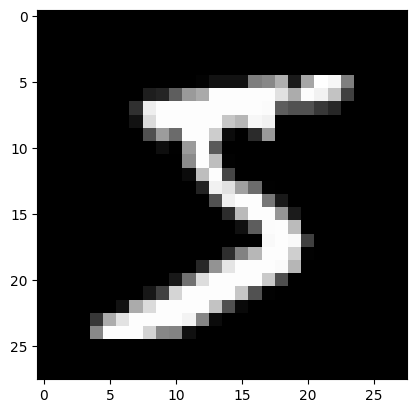

In [114]:
train_imagefile = 'mnist_dataset/train-images.idx3-ubyte'
train_imagearray = idx2numpy.convert_from_file(train_imagefile)

train_labelfile = 'mnist_dataset/train-labels.idx1-ubyte'
train_labelarray = idx2numpy.convert_from_file(train_labelfile)

test_imagefile = 'mnist_dataset/t10k-images.idx3-ubyte'
test_imagearray = idx2numpy.convert_from_file(test_imagefile)

test_labelfile = 'mnist_dataset/t10k-labels.idx1-ubyte'
test_labelarray = idx2numpy.convert_from_file(test_labelfile)

# put image and label together as a tuple
train_data = []
for i in range(len(train_imagearray)):
    train_data.append((train_imagearray[i], train_labelarray[i]))

test_data = []
for i in range(len(test_imagearray)):
    test_data.append((test_imagearray[i], test_labelarray[i]))

print(train_data[0][1])
plt.imshow(train_data[0][0], cmap='gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [116]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, 3, 1, 1).to(device)
        self.conv2 = torch.nn.Conv2d(8, 16, 3, 1, 1).to(device)
        self.pool = torch.nn.MaxPool2d(2, 2).to(device)
        self.fc2 = torch.nn.Linear(16*14*14, 10).to(device)
    
    def forward(self, x):
        x = self.conv1(x).to(device)
        x = self.pool(x).to(device)
        x = self.conv2(x).to(device)
        x = x.view(-1, 16*14*14).to(device)
        x = self.fc2(x).to(device)
        return x

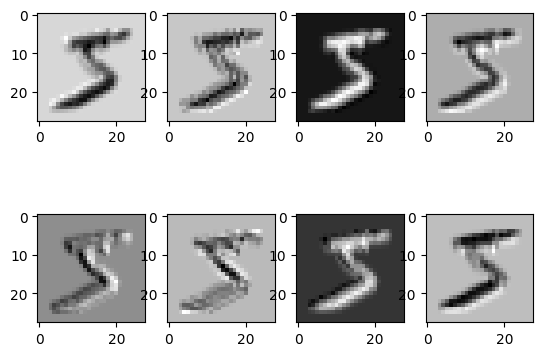

In [117]:
model = CNN()
conv1_res = model.conv1((torch.tensor(train_data[0][0]).to(device).unsqueeze(0).unsqueeze(0).float())).to(device)
conv1_res = conv1_res.detach().cpu().numpy()

# draw plots in subplots
num_rows = 2
num_cols = len(conv1_res[0]) // num_rows
fig, axs = plt.subplots(num_rows, num_cols)
for i in range(num_rows):
    for j in range(num_cols):
        axs[i, j].imshow(conv1_res[0, i*num_cols+j], cmap='gray')

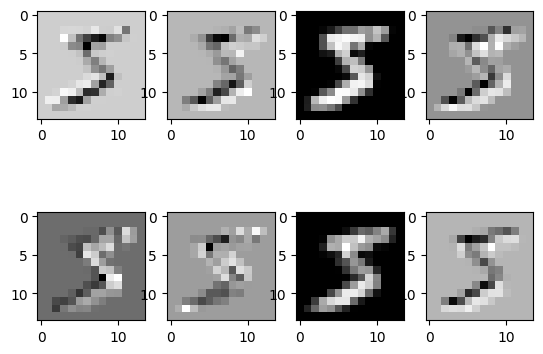

In [118]:
pool_res = model.pool(torch.tensor(conv1_res).to(device)).to(device)
pool_res = pool_res.detach().cpu().numpy()

num_rows = 2
num_cols = len(pool_res[0]) // num_rows
fig, axs = plt.subplots(num_rows, num_cols)
for i in range(num_rows):
    for j in range(num_cols):
        axs[i, j].imshow(pool_res[0, i*num_cols+j], cmap='gray')

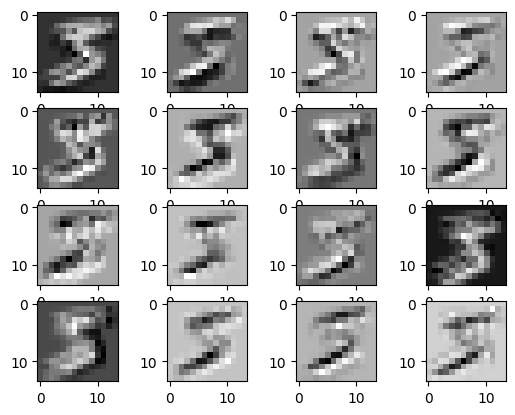

In [119]:
conv2_res = model.conv2(torch.tensor(pool_res).to(device)).to(device)
conv2_res = conv2_res.detach().cpu().numpy()

num_rows = 4
num_cols = len(conv2_res[0]) // num_rows
fig, axs = plt.subplots(num_rows, num_cols)
for i in range(num_rows):
    for j in range(num_cols):
        axs[i, j].imshow(conv2_res[0, i*num_cols+j], cmap='gray')

In [120]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

batch_size = 25
data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for epoch in range(100):
    for i, (img, label) in enumerate(data_loader):
        y = model(torch.tensor(img).to(device).unsqueeze(1).float())
        loss = criterion(y, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}, loss: {}'.format(epoch, loss.item()))

/tmp/ipykernel_16036/1686582531.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = model(torch.tensor(img).to(device).unsqueeze(1).float())


epoch: 0, loss: 0.05183359980583191
epoch: 10, loss: 0.040902331471443176
epoch: 20, loss: 0.0009636541362851858
epoch: 30, loss: 0.008416598662734032
epoch: 40, loss: 0.006632817909121513
epoch: 50, loss: 0.001878458890132606
epoch: 60, loss: 0.0005995931569486856
epoch: 70, loss: 0.0006593329599127173
epoch: 80, loss: 0.003754150355234742
epoch: 90, loss: 0.5254517197608948


accuracy test data set: 0.9667999744415283


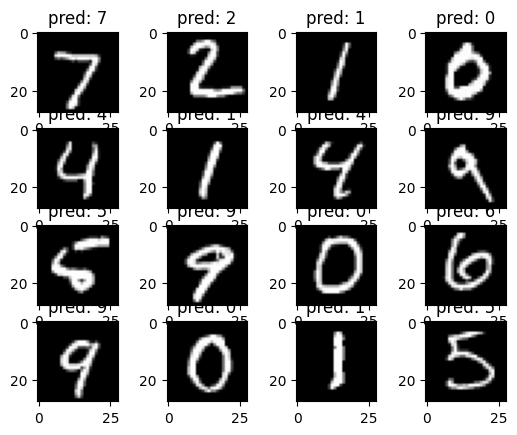

In [127]:
def accuracy(y, y_pred):
    y_pred = torch.argmax(y_pred, dim=1)
    return (y == y_pred).float().mean()

# y_train = torch.tensor([data[1] for data in train_data]).to(device)
# y = model(torch.tensor([data[0] for data in train_data]).to(device).unsqueeze(1).float())
y_test = torch.tensor([data[1] for data in test_data]).to(device)
y_pred = model(torch.tensor([data[0] for data in test_data]).to(device).unsqueeze(1).float())

# print('accuracy train data set: {}'.format(accuracy(y_train, y).item()))
print('accuracy test data set: {}'.format(accuracy(y_test, y_pred).item()))

# draw plots in subplots
num_rows = 4
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols)
for i in range(num_rows):
    for j in range(num_cols):
        axs[i, j].imshow(test_imagearray[i*num_cols+j], cmap='gray')
        axs[i, j].set_title('pred: {}'.format(torch.argmax(y_pred[i*num_cols+j]).item()))